In [2]:

import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np


In [3]:
import os

ROOT_DIR = '/content/drive/MyDrive/classfication_image/tomato_leaf'


TRAIN_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'train')
VALIDATION_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'valid')
TEST_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'test')

In [4]:
check_label_directory = os.path.join(TEST_DATA_ROOT_DIR, 'labels')
check_image_directory = os.path.join(TEST_DATA_ROOT_DIR, 'images')

labels = os.listdir(check_label_directory)

for label in labels:
  with open(os.path.join(check_label_directory, label),'r') as file_in:
    contents =file_in.read()
  if contents == "":
    filenametoremove = label.split('.txt')[0]
    print ('filenametoremove: ', filenametoremove)

    os.remove(os.path.join(check_label_directory, filenametoremove+'.txt'))
    os.remove(os.path.join(check_image_directory, filenametoremove+'.jpg'))
    print (os.path.join(check_label_directory, filenametoremove+'.txt'))
    print (os.path.join(check_label_directory, filenametoremove+'.txt'))
    print ("==========")


In [5]:
DEVICE = torch.device ("cuda") if torch.cuda.is_available() else torch.device("cpu")
print (f"using Pytorch version: {torch.__version__}, Device: {DEVICE}")

using Pytorch version: 2.4.0+cu121, Device: cuda


In [6]:
import os
import torchvision
image_dir = os.path.join(TRAIN_DATA_ROOT_DIR,'images')
print("Train images: ", len(os.listdir(image_dir)))
print("Validation images: ", len(os.listdir(VALIDATION_DATA_ROOT_DIR)))
print("Test images: ", len(os.listdir(TEST_DATA_ROOT_DIR)))
img_name = os.listdir(image_dir)[0]
img_path = os.path.join(image_dir,img_name)
img = torchvision.io.read_image(img_path)

print ("image size : ", img.shape)

Train images:  627
Validation images:  3
Test images:  2
image size :  torch.Size([3, 640, 640])


In [7]:
train_config = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((224,224)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()])
validation_config = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor()])

In [8]:
import os
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, folder_dir, transform=None, target_transform=None):

    self.labels_dir = os.path.join(folder_dir, 'labels')
    self.img_dir = os.path.join(folder_dir,'images')
    self.label_list = os.listdir(self.labels_dir)
    self.img_list = os.listdir(self.img_dir)


    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    image_name = self.img_list[idx]
    label_name = image_name.split('.jpg')[0]+'.txt'

    with open(os.path.join(self.labels_dir, label_name),'r') as file_in:
      contents =file_in.read()
    label = int(contents.split(' ')[0])
    image = read_image(os.path.join(self.img_dir,image_name))

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [9]:
test=CustomImageDataset(TRAIN_DATA_ROOT_DIR)

In [10]:
train_dataset = CustomImageDataset(TRAIN_DATA_ROOT_DIR, train_config)

validation_dataset = CustomImageDataset(VALIDATION_DATA_ROOT_DIR, validation_config)

test_dataset = CustomImageDataset(TEST_DATA_ROOT_DIR, validation_config)

In [11]:
images, labels = next(iter(train_dataset))
print (images.shape)
print (type(labels))

torch.Size([3, 224, 224])
<class 'int'>


In [12]:
BATCH_SIZE = 32

train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
images, labels = next(iter(train_dataset_loader))
print (images.shape)

print (labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


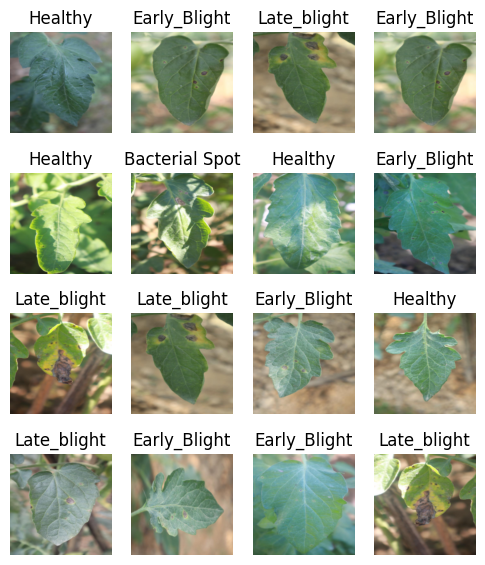

In [49]:
import matplotlib.pyplot as plt

labels_map = {0: "Bacterial Spot",
  1: "Early_Blight",
  2: "Healthy",
  3: "Late_blight",
  4: "Leaf Mold",
  5: "Target_Spot",
  6: "black spot"
 }

figure = plt.figure(figsize=(6, 7))

cols, rows = 4, 4
for i in range(1, cols*rows+1):

    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)

    plt.title(labels_map[label])
    plt.axis("off")

    # convert imager shape from (3, 224, 224) to (224, 224, 3)
    plt.imshow(torch.permute(img, (1, 2, 0)))

plt.show()


In [15]:
from torchvision import  models
pretrained_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [16]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self, pretrained_model, feature_extractor):

        super().__init__()

        if (feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad = False

        # modify header
        pretrained_model.heads = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.heads[0].in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 7) # 7 type of tomato leaves
        )

        self.model = pretrained_model

    def forward(self, data):

        logits = self.model(data)

        return logits

In [17]:
feature_extractor = False  # True for Feature Extractor,  False for Fine Tuning

model = MyTransferLearningModel(pretrained_model, feature_extractor).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [18]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader =DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [19]:
loss_function = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr = 1e-6)

In [20]:
def model_train(dataloader, model, loss_function, optimizer):

    # training mode
    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)


In [21]:
def model_evaluate(dataloader, model, loss_function, optimizer):

  # evaluation mode
    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [22]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)



In [26]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 40

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 1.285 train acc = 59.490 val loss = 1.334 val acc = 57.627
epoch: 02 train loss = 1.250 train acc = 62.998 val loss = 1.296 val acc = 59.322
epoch: 03 train loss = 1.219 train acc = 66.188 val loss = 1.263 val acc = 61.017
epoch: 04 train loss = 1.170 train acc = 67.624 val loss = 1.229 val acc = 62.712
epoch: 05 train loss = 1.137 train acc = 69.856 val loss = 1.198 val acc = 62.712
epoch: 06 train loss = 1.069 train acc = 73.206 val loss = 1.163 val acc = 62.712
epoch: 07 train loss = 1.036 train acc = 74.482 val loss = 1.132 val acc = 64.407
epoch: 08 train loss = 0.995 train acc = 76.077 val loss = 1.105 val acc = 64.407
epoch: 09 train loss = 0.952 train acc = 78.947 val loss = 1.070 val acc = 69.492
epoch: 10 train loss = 0.919 train acc = 78.947 val loss = 1.045 val acc = 72.881
epoch: 11 train loss = 0.881 train acc = 80.064 val loss = 1.014 val acc = 74.576
epoch: 12 train loss = 0.845 train acc = 82.456 val loss = 0.995 val acc = 74.576
epoch: 13 train 

In [27]:
model_test(test_dataset_loader, model)

accuracy: 87.09677419354838
loss: 0.43653643131256104


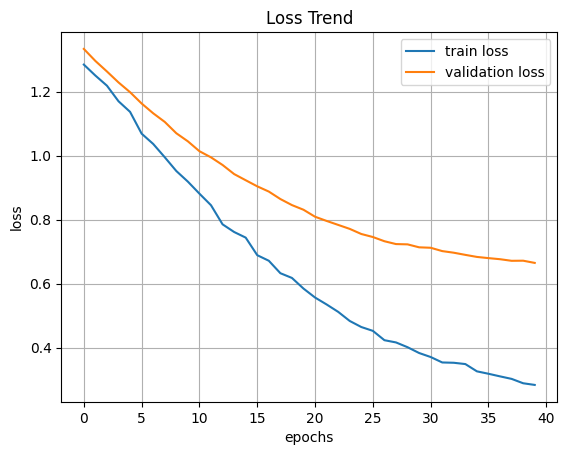

In [28]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()

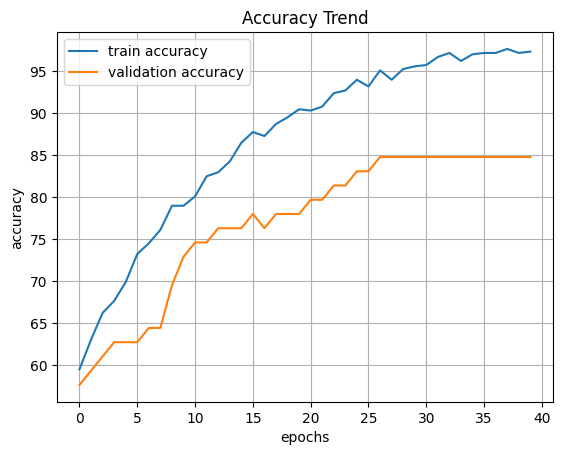

In [29]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

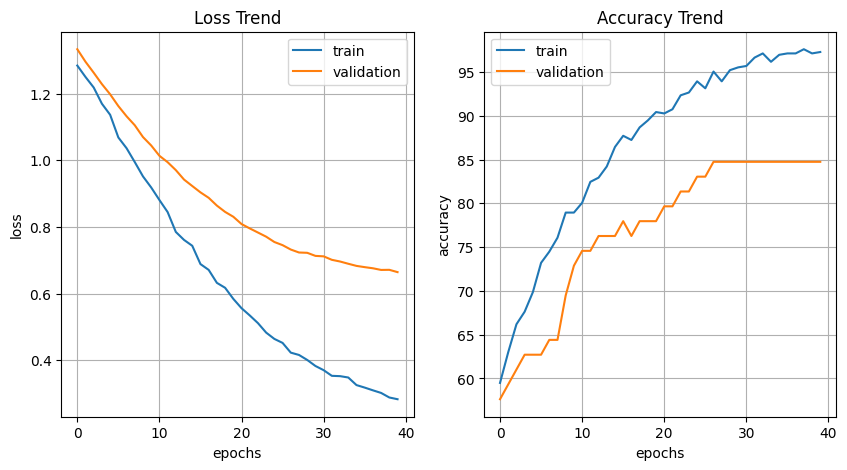

In [30]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()

In [31]:
test_images_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_images_loader))

x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# inferencing images
outputs = model(x_test)

_, preds = torch.max(outputs, 1)  # find prediction

print('label => ', y_test)
print('preds => ', preds)


label =>  tensor([3, 2, 2, 1, 1, 1, 1, 2, 1, 3, 1, 3, 5, 3, 1, 1, 1, 2, 2, 1, 1, 3, 5, 1,
        0, 3, 3, 1, 2, 3, 2], device='cuda:0')
preds =>  tensor([3, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1,
        6, 3, 3, 1, 2, 3, 2], device='cuda:0')


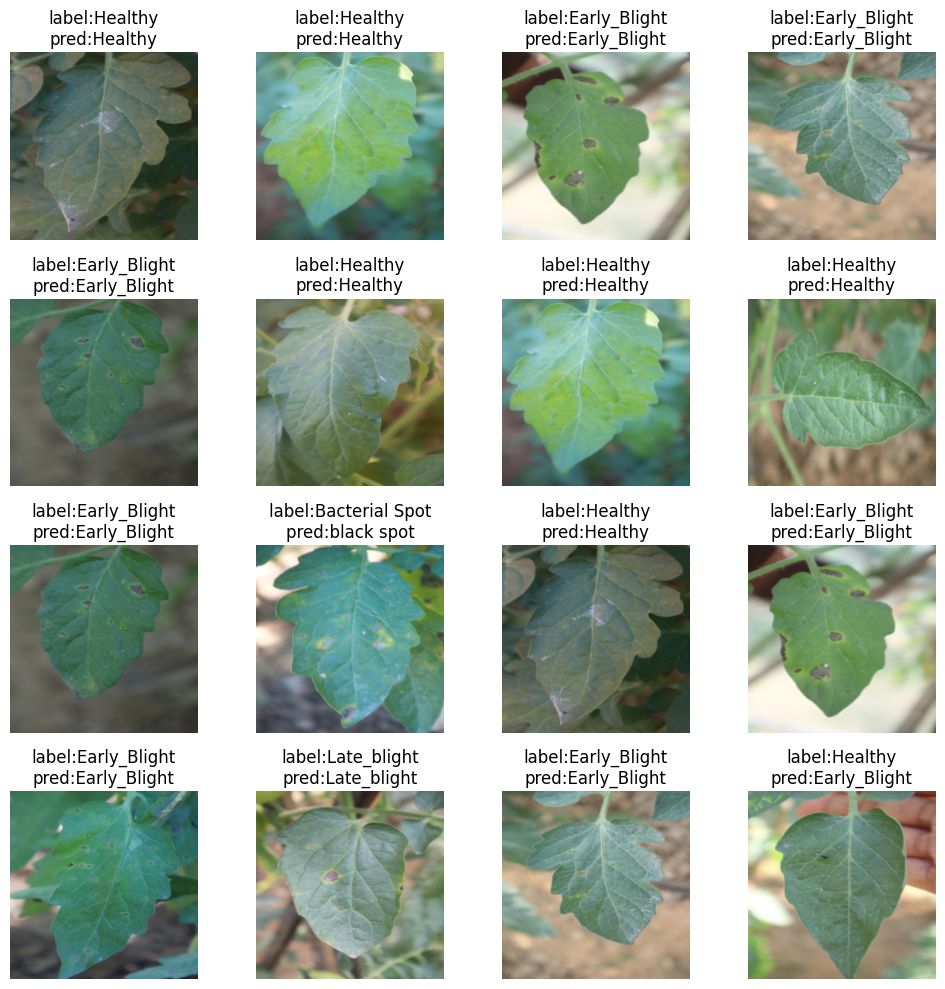

In [46]:
import matplotlib.pyplot as plt

labels_map = {0: "Bacterial Spot",
  1: "Early_Blight",
  2: "Healthy",
  3: "Late_blight",
  4: "Leaf Mold",
  5: "Target_Spot",
  6: "black spot"
 }

plt.figure(figsize=(10,10))

cols, rows = 4, 4

for pos in range(cols*rows):

    plt.subplot(4,4,pos+1)

    sample_idx = torch.randint(len(x_test), size=(1,)).item()

    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.axis('off')

    # convert image shape from (3, 224, 224) to (224, 224, 3)
    plt.imshow(torch.permute(img, (1, 2, 0)))

plt.tight_layout()
plt.show()

In [40]:
# Specify a path to save medel's parameters
PATH = "/content/drive/MyDrive/models/tomato_leaf/state_dict_model.pt"

torch.save(model.state_dict(), PATH)

In [42]:
# Load for inference
base_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
feature_extractor = False

model_inference = MyTransferLearningModel(base_model, feature_extractor).to(DEVICE)

model_inference.load_state_dict(torch.load(PATH, weights_only=True))
model_inference.eval()

MyTransferLearningModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
         

In [43]:
test_images_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_images_loader))

x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# inferencing images
outputs = model_inference(x_test)

_, preds = torch.max(outputs, 1)  # find prediction


print('label => ', y_test)
print('preds => ', preds)

label =>  tensor([3, 2, 2, 1, 1, 1, 1, 2, 1, 3, 1, 3, 5, 3, 1, 1, 1, 2, 2, 1, 1, 3, 5, 1,
        0, 3, 3, 1, 2, 3, 2], device='cuda:0')
preds =>  tensor([3, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1,
        6, 3, 3, 1, 2, 3, 2], device='cuda:0')
